# Linear Elasticity: bending of an orthotropic beam

This notebook serves as a example of the use of variational formulations in elasticity. 

We implement a finite element solver for orthotropic 3d beam.

This tutorial is based on the use of `FEniCS/dolfinx`, an open-source finite-element library with a python interface.

You can find a tutorial and useful resources for DOLFINx at the following links

- https://docs.fenicsproject.org/
- https://github.com/FEniCS/dolfinx/
- https://jorgensd.github.io/dolfinx-tutorial/, see https://jorgensd.github.io/dolfinx-tutorial/chapter2/linearelasticity.html for linear elasticity


FEniCSX is advanced library that allows for efficient parallel computation. For the sake of simplicity, we assume here to work on a single processor and will not use MPI-related commands. 

In [1]:
# Import required libraries
import matplotlib.pyplot as plt
import numpy as np
import dolfinx
import ufl

from mpi4py import MPI
from petsc4py import PETSc
from petsc4py.PETSc import ScalarType


# Mesh
Let us generate a simple mesh. More complex and realistic meshes can be generated with [gmsh](http://gmsh.info/.)


In [2]:
L = 1.
W = 0.2

refinement = 5
domain = dolfinx.mesh.create_box(MPI.COMM_WORLD, [np.array([0,0,0]), np.array([L, W, W])],
                  [10*refinement,3*refinement,3*refinement], cell_type=dolfinx.mesh.CellType.hexahedron)

domain_dimension = domain.topology.dim
facet_dimension = domain.topology.dim - 1
print(f"We have a {domain_dimension}-d mesh with {facet_dimension}-d boundary")

We have a 3-d mesh with 2-d boundary


To plot the mesh we use `pyvista` see:
- https://jorgensd.github.io/dolfinx-tutorial/chapter3/component_bc.html
- https://docs.fenicsproject.org/dolfinx/main/python/demos/pyvista/demo_pyvista.py.html

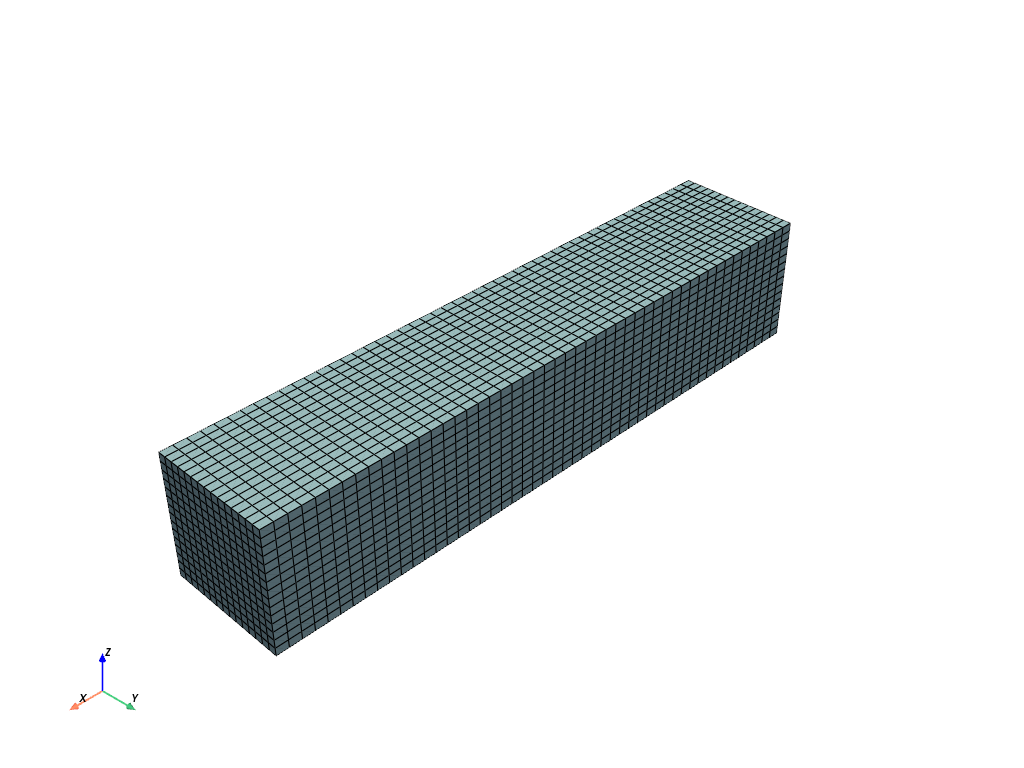

In [3]:
import pyvista
pyvista.set_jupyter_backend("static")

grid = pyvista.UnstructuredGrid(*dolfinx.plot.create_vtk_mesh(domain))
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.show_axes()
plotter.show()

## Finite element function space

We use here linear Lagrange triangle elements

In [4]:
V = dolfinx.fem.VectorFunctionSpace(domain, ("Lagrange", 1))

## Dirichlet boundary conditions

We define below the functions to impose the Dirichlet boundary conditions.

In our case we want to block the displacement at the left-end

We first get the facets to block on the boundary (`dolfinx.mesh.locate_entities_boundary`) and then the corresponding dofs (`dolfinx.fem.locate_dofs_topological`). The following lines define the `dolfinx.fem.dirichletbc` objects. We impose a zero displacement.

In [5]:
def left(x):
    return np.isclose(x[0], 0.0)
left_facets = dolfinx.mesh.locate_entities_boundary(domain, facet_dimension, left)
left_dofs = dolfinx.fem.locate_dofs_topological(V, facet_dimension, left_facets)
bc_value = np.array([0,0,0],dtype=ScalarType)
bc_left = dolfinx.fem.dirichletbc(bc_value, left_dofs, V)
bcs = [bc_left]


## Define the variational problem 

We specify the problem to solve though the weak formulation written in the [ufl](https://fenics.readthedocs.io/projects/ufl/en/latest/) syntax by giving the bilinear $a(u,v)$ and linear forms $L(v)$ in 
the weak formulation: 

find the *trial function* $u$ such that for all *test function* $v$
$$a(u,v)=L(v)$$ 
with 
$$
a(u,v)=\int_{\Omega\setminus\Gamma}\sigma(\varepsilon(u))\cdot \varepsilon(v)\,\mathrm{d}x, 
\quad L(v)=\int_\Omega b\cdot v \,\mathrm{d}x + \int_{\partial_N\Omega} f\cdot v \,\mathrm{d}s 
$$

**Define the bulk and surface mesures.** 
The bulk (`dx`) and surface (`ds`) measures are used by `ufl` to write variational form with integral over the domain or the boundary, respectively. In this example the surface measure `ds` includes tags to specify Neumann bcs: `ds(1)` will mean the integral on the right boundary. We need it to impose the force 

In [6]:
dx = ufl.Measure("dx", domain=domain)

def right(x):
    return np.isclose(x[0],1)
right_facets = dolfinx.mesh.locate_entities_boundary(domain, facet_dimension, right)
mt = dolfinx.mesh.meshtags(domain, facet_dimension, right_facets, 1)
ds = ufl.Measure("ds", subdomain_data=mt, domain=domain)

Note on UFL terminology:
- `ufl.inner(sigma(eps(u)), eps(v))` is an expression
- `ufl.inner(sigma(eps(u)), eps(v)) * dx` is a form, an integral on a domain

We use the Voigt notation to represent the orthotropic behaviour

$$  [\mathsf{S}] = 
  \begin{bmatrix}
    \tfrac{1}{E_{\rm 1}} & - \tfrac{\nu_{\rm 12}}{E_{\rm 1}} & - \tfrac{\nu_{\rm 13}}{E_{\rm 1}} & 0 & 0 & 0 \\
    -\tfrac{\nu_{\rm 21}}{E_{\rm 2}} & \tfrac{1}{E_{\rm 2}} & - \tfrac{\nu_{\rm 23}}{E_{\rm 2}} & 0 & 0 & 0 \\
    -\tfrac{\nu_{\rm 31}}{E_{\rm 3}} & - \tfrac{\nu_{\rm 32}}{E_{\rm 3}} & \tfrac{1}{E_{\rm 3}} & 0 & 0 & 0 \\
    0 & 0 & 0 & \tfrac{1}{G_{\rm 23}} & 0 & 0 \\
    0 & 0 & 0 & 0 & \tfrac{1}{G_{\rm 31}} & 0 \\
    0 & 0 & 0 & 0 & 0 & \tfrac{1}{G_{\rm 12}} \\
    \end{bmatrix}
    \qquad
    \begin{bmatrix} \varepsilon_1 \\ \varepsilon_2 \\ \varepsilon_3 \\ \varepsilon_4 \\ \varepsilon_5  \\ \varepsilon_6\end{bmatrix},
    \qquad
[\varepsilon]=
\begin{bmatrix}\varepsilon_{11} \\ \varepsilon_{22} \\ \varepsilon_{33} \\ 2\varepsilon_{23} \\ 2\varepsilon_{13} \\ 2\varepsilon_{12} \end{bmatrix}
\qquad
[\sigma]=
\begin{bmatrix} \sigma_1 \\ \sigma_2 \\ \sigma_3 \\ \sigma_4 \\ \sigma_5  \\ \sigma_6\end{bmatrix}
=
\begin{bmatrix}\sigma_{11} \\ \sigma_{22} \\ \sigma_{33} \\ \sigma_{23} \\ \sigma_{13} \\ \sigma_{12} \end{bmatrix}\\
$$
$$
[\sigma]=[\mathsf{C}][\varepsilon],
\qquad
\underline{\underline{\sigma}}:\underline{\underline{\varepsilon}}=[\sigma].[\varepsilon],\qquad, [\mathsf{C}]=[\mathsf{S}]^{-1}
$$

In [7]:
E0 = 10000
Ex = 1.
Ey = 858./E0
Ez = 456./E0
nuxy = 0.34
nuxz = 0.42
nuyz = 0.29
Gyz = 155./E0
Gxz = 538./E0
Gxy = 786./E0

S_voigt_np = np.array([[1./Ex,- nuxy/Ex,-nuyz/Ey,0,0,0],
                         [-nuxy/Ex, 1./Ey,1./Ez,0,0,0],
                         [-nuxz/Ex,-nuyz/Ey,1/Ez,0,0,0],
                         [0,0,0,1./Gyz,0,0],
                         [0,0,0,0,1./Gxz,0],
                         [0,0,0,0,0,1./Gxy]])

C_voigt_np = np.linalg.inv(S_voigt_np)


def eps_voigt(u):
    return ufl.as_vector([u[0].dx(0), #uxx
                          u[1].dx(1), #uyy
                          u[2].dx(2), #zz
                          u[2].dx(1)+u[1].dx(2), #uyz+uzy
                          u[0].dx(2)+u[2].dx(0),
                          u[1].dx(0)+u[0].dx(1)])
    
def sigma_voigt(eps):
    C_voigt = ufl.as_matrix(C_voigt_np) 
    # Uncomment the line below to show the example of a beam made of two layers
    # C_voigt = ufl.conditional(x[1] > W/3, ufl.as_matrix(C_voigt_np), 10 * ufl.as_matrix(C_voigt_np))
    return C_voigt * eps

We define below the bilinear and linear form needed for the variational formulation

In [8]:
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

x = ufl.SpatialCoordinate(domain)
C = 0.1


def a(u,v):
    """The bilinear form of the weak formulation"""
    return ufl.inner(sigma_voigt(eps_voigt(u)), eps_voigt(v)) * dx

def L(v): 
    """The linear form of the weak formulation"""
    # Volume force
    b = dolfinx.fem.Constant(domain,ScalarType((0, 0, 0)))

    # Surface force on the top
    f = ufl.as_vector([- C * x[1], 0, 0])
    #return ufl.dot(b, v) * dx + ufl.dot(f, v) * ds(1)    
    return ufl.inner(b, v) * dx + ufl.dot(f, v) * ds

## Define the linear problem and solve
We solve the problem using a direct solver. The class `dolfinx.fem.LinearProblem` assemble the stiffness matrix and load vector, apply the boundary conditions, and solve the linear system.

In [9]:
problem = dolfinx.fem.petsc.LinearProblem(a(u,v), L(v), bcs=bcs, 
                                    petsc_options={"ksp_type": "gmres", "pc_type": "gamg"})
uh = problem.solve()
uh.name = "displacement"

## Postprocessing

We can easily calculate the potential energy

In [10]:
elastic_energy = dolfinx.fem.assemble_scalar(dolfinx.fem.form(0.5 * a(uh, uh)))
print(f"The elastic energy energy is {elastic_energy:2.3e}")

external_work= dolfinx.fem.assemble_scalar(dolfinx.fem.form(L(uh)))
print(f"The external work is {external_work:2.3e}")

The elastic energy energy is 7.108e-04
The external work is 1.422e-03


We can save the results to a file, that we can open with `paraview` (https://www.paraview.org/)

In [11]:
with dolfinx.io.XDMFFile(MPI.COMM_WORLD, "output/elasticity-demo.xdmf", "w") as file:
    file.write_mesh(uh.function_space.mesh)
    file.write_function(uh)

Let us plot the solution using `pyvista`, see
- https://jorgensd.github.io/dolfinx-tutorial/chapter3/component_bc.html
- https://docs.fenicsproject.org/dolfinx/v0.5.0/python/demos/demo_pyvista.html

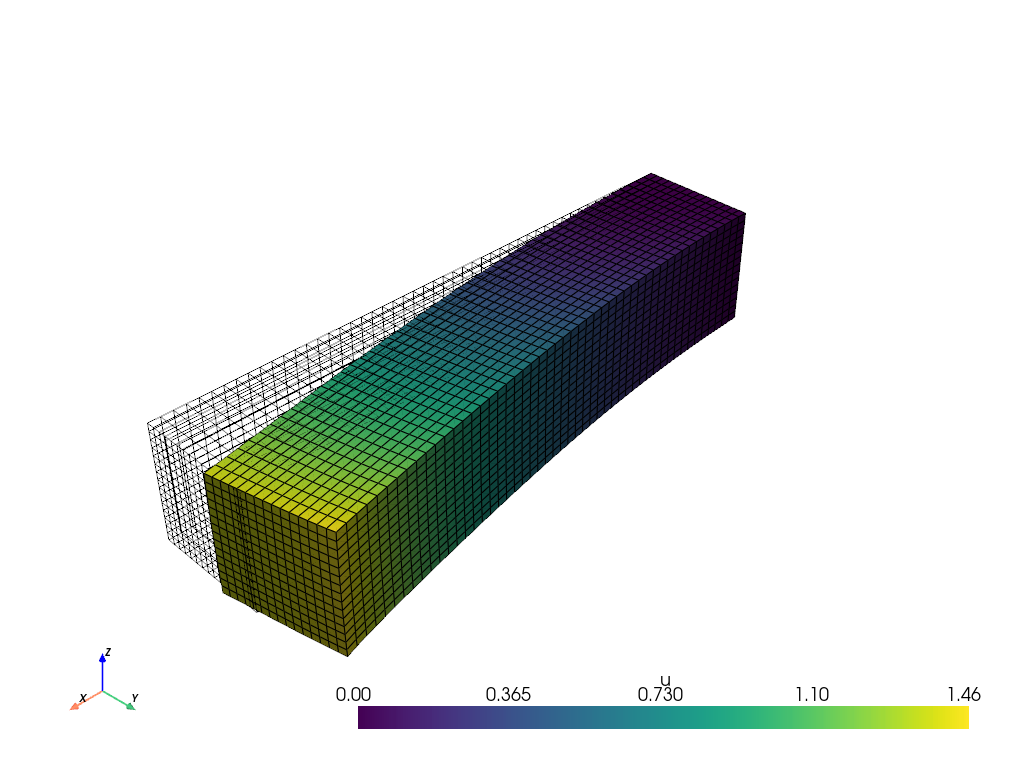

In [19]:
import pyvista
pyvista.set_jupyter_backend("static") #

# Create plotter and pyvista grid
p = pyvista.Plotter()
topology, cell_types, geometry = dolfinx.plot.create_vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

# Attach vector values to grid and warp grid by vector
grid["u"] = uh.x.array.reshape((geometry.shape[0], 3))
actor_0 = p.add_mesh(grid, style="wireframe", color="k")
warped = grid.warp_by_vector("u", factor=.1)
actor_1 = p.add_mesh(warped, show_edges=True,show_scalar_bar=True)
p.show_axes()
p.show()

## Stress computation

We calculate here the Von Mises stress by interpolating the corresponding ufl expression, see https://jorgensd.github.io/dolfinx-tutorial/chapter2/linearelasticity_code.html#stress-computation

In [ ]:
stress = sigma_voigt(eps_voigt(uh)) 

V_stress = dolfinx.fem.VectorFunctionSpace(domain, ("DG", 0), dim=6)
stress_expr = dolfinx.fem.Expression(stress, V_stress.element.interpolation_points())
stress_function = dolfinx.fem.Function(V_stress,name="sigma")
stress_function.interpolate(stress_expr)    

with dolfinx.io.XDMFFile(MPI.COMM_WORLD, "output/elasticity-demo-stress.xdmf", "w") as file:
    file.write_mesh(domain)    
    file.write_function(stress_function)

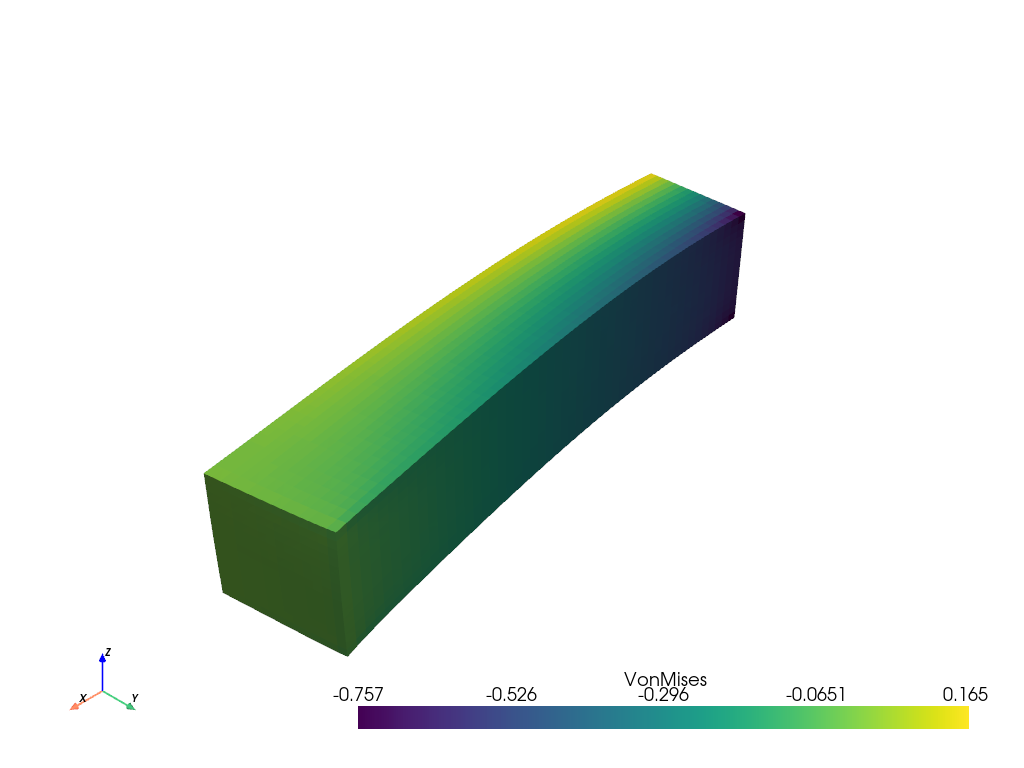

In [ ]:

V_stress_scalar = dolfinx.fem.FunctionSpace(domain, ("DG", 0))
stress_xx_expr = dolfinx.fem.Expression(stress[0], V_stress_scalar.element.interpolation_points())
stress_xx_function = dolfinx.fem.Function(V_stress_scalar,name="sigmaxx")
stress_xx_function.interpolate(stress_xx_expr)


warped.cell_data["VonMises"] = stress_xx_function.vector.array
warped.set_active_scalars("VonMises")
p = pyvista.Plotter()
p.add_mesh(warped)
p.show_axes()
p.show()